<a href="https://colab.research.google.com/github/baotram153/Reinforcement-Learning/blob/main/notebooks/Off_Policy_Methods_with_Function_Approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

## Bard's counter example

In [ ]:
class BardEnvironment:  # zero reward for all transition
    def __init__(self) -> None:
        self.n_states = 7
        self.state_space = np.arange(self.n_states)

    def get_behavior_next_state(self):   # get action from behavior policy
        return np.random.choice(self.state_space)

    def get_target_next_state(self):
        return 6

    def get_importance_sampling (self, new_state):
        if (new_state != 6): return 0
        else: return 7  # pi / b

In [ ]:
class BardValueFunction:
    def __init__(self, alpha) -> None:  # 7 states: index 0 -> 6
        self.alpha = alpha
        self.params = np.array([1, 1, 1, 1, 1, 1, 10, 1])

        # set up feature vector for each state
        self.feature_vector = np.zeros((7,8))
        for i in range (6):
            self.feature_vector[i, 7] = 1
            self.feature_vector[i, i] = 2
        self.feature_vector[6, 7] = 2
        self.feature_vector[6, 6] = 1

    def get_state_value (self, state):
        return np.dot(self.feature_vector[state], self.params)

    def update (self, state, delta, importance_sampling):
        self.params = self.params + self.alpha*importance_sampling*delta*self.feature_vector[state]

In [ ]:
class Graphing ():
    def __init__(self) -> None:
        self.n_params = 8
        self.weights = [[] for _ in range(self.n_params)]

    def store_weights (self, params):
        for i in range (self.n_params):
            # print(self.weights)
            self.weights[i].append(params[i])

    def plot_weights(self, n_steps):
        for i in range(self.n_params):
            plt.plot(np.arange(n_steps), self.weights[i])
        plt.show()

### Semi-gradient Off-policy TD(0)

In [ ]:
def semi_gradient_off_policy_TD (n_steps, alpha, gamma):
    env = BardEnvironment()
    value_func = BardValueFunction(alpha)
    graph = Graphing()
    old_state = env.get_behavior_next_state()
    for step in range(n_steps):
        new_state = env.get_behavior_next_state()
        importance_sampling = env.get_importance_sampling(new_state)
        delta = 0 + gamma*value_func.get_state_value(new_state) - value_func.get_state_value(old_state)
        value_func.update(old_state, delta, importance_sampling)
        old_state = new_state
        graph.store_weights(value_func.params)
    return graph

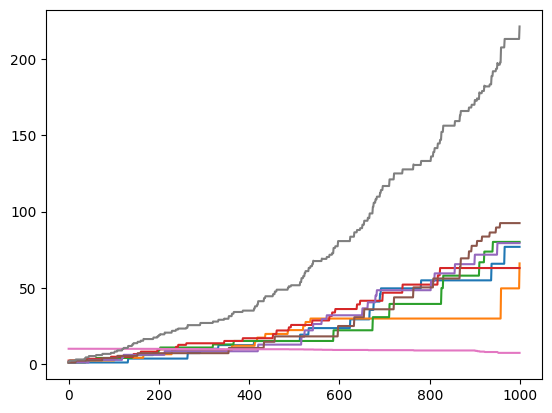

In [ ]:
n_steps = 1000
graph = semi_gradient_off_policy_TD(n_steps, alpha=0.01, gamma = 0.99)
graph.plot_weights(n_steps)

### Semi-gradient Dynamic Programming

In [ ]:
def semi_gradient_DP (n_steps, alpha, gamma):
    env = BardEnvironment()
    value_func = BardValueFunction(alpha / env.n_states)    # set different lr
    graph = Graphing()
    for step in range(n_steps):
        new_state = env.get_target_next_state()
        target_value = value_func.get_state_value(new_state)
        for state in env.state_space:
            delta = 0 + gamma*target_value - value_func.get_state_value(state)
            value_func.update(state, delta, 1)
        graph.store_weights(value_func.params)
    return graph

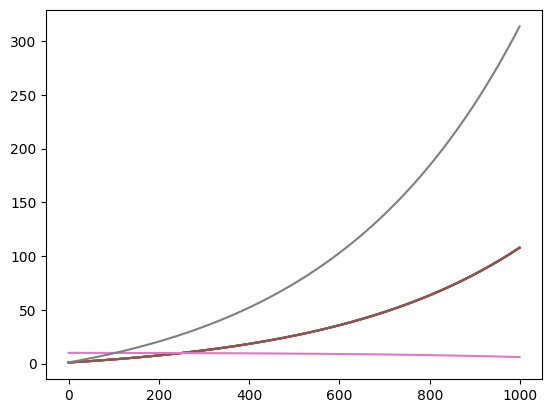

In [ ]:
n_steps = 1000
graph = semi_gradient_DP(n_steps, alpha=0.01, gamma=0.99)
graph.plot_weights(n_steps)

## Learnability

### Naive Residual Gradient

#### Algorithm

In [ ]:
def naive_residual_gradient(n_eps, env, alpha, gamma = 1):
    for ep in range(n_eps):
        old_state = env.get_first_state()
        while True:
            new_state = env.get_new_state(old_state)
            new_transition = old_state + new_state
            reward = env.get_reward(new_transition)
            delta = reward + gamma*env.get_state_value(new_state) - env.get_state_value(old_state)
            env.update(new_transition, delta)
            if (new_state == 'T'): break
            old_state = new_state
    return env.params

#### A Split counterexample

In [ ]:
class ASplit:
    def __init__(self, alpha) -> None:
        self.reward_dict = {'AB': 0, 'AC': 0, 'BT' : 1, 'CT' : 0}
        self.transition_dict = {'A' : ['B','C'], 'B' : ['T'], 'C' : ['T']}
        self.params = np.zeros(3)   # A = 0, B = 1, C = 2
        self.alpha = alpha
        self.feature_vector = [np.zeros(3) for _ in range(3)]
        for i in range(3):
            self.feature_vector[i][i] = 1

    def get_first_state(self):
        return 'A'

    def get_new_state (self, state):
        return np.random.choice(self.transition_dict[state])

    def get_reward (self, transition):
        return self.reward_dict[transition]

    def update (self, transition, delta):
        if (transition[1] == 'T'):
            grad_delta = self.feature_vector[ord(transition[0]) - ord('A')]
        else:
            grad_delta = self.feature_vector[ord(transition[0]) - ord('A')] - self.feature_vector[ord(transition[1]) - ord('A')]
        self.params += self.alpha*delta*grad_delta

    def get_state_value (self, state):
        if (state == 'A'): return self.params[0]
        elif (state == 'B'): return self.params[1]
        elif (state == 'C'): return self.params[2]
        else: return 0

In [ ]:
alpha = 10**(-3)
env = ASplit(alpha)
state_values = naive_residual_gradient(n_eps=50000, env=env, alpha=alpha)
print(state_values)

[0.50369185 0.75283911 0.25267073]


### Residual Gradient

#### Algorithm

In [ ]:
def residual_gradient(n_eps, env, alpha, gamma = 1):
    for ep in range(n_eps):
        old_state = env.get_first_state()
        while True:
            new_state1 = env.get_new_state(old_state)
            new_state2 = env.get_new_state(old_state)
            new_transition1 = old_state + new_state1
            new_transition2 = old_state + new_state2
            reward = env.get_reward(new_transition1)
            delta = reward + gamma*env.get_state_value(new_state1) - env.get_state_value(old_state)
            env.update(new_transition2, delta)
            if (new_state1 == 'T'): break
            old_state = new_state1
    return env.params

#### A Pre-split counterexample

In [ ]:
class APresplit:
    def __init__(self, alpha) -> None:
        self.reward_dict = {'AB': 0, 'aC': 0, 'BT' : 1, 'CT' : 0}
        self.transition_dict = {'A' : ['B'], 'a' : ['C'], 'B' : ['T'], 'C' : ['T']}
        self.params = np.zeros(3)   # A = 0, B = 1, C = 2
        self.alpha = alpha
        self.feature_vector = [np.zeros(3) for _ in range(3)]
        for i in range(3):
            self.feature_vector[i][i] = 1
    def state_to_idx (self, state):
        if (state == 'A' or state == 'a'): return 0
        if (state == 'B'): return 1
        if (state == 'C'): return 2

    def get_first_state(self):
        return np.random.choice(['A', 'a'])

    def get_new_state (self, state):
        return np.random.choice(self.transition_dict[state])

    def get_reward (self, transition):
        return self.reward_dict[transition]

    def update (self, transition, delta):
        grad_delta = np.zeros(3)
        grad_delta[self.state_to_idx(transition[0])] = 1
        if (transition[1] != 'T'): grad_delta[self.state_to_idx(transition[1])] = -1
        self.params += self.alpha*delta*grad_delta

    def get_state_value (self, state):
        if (state == 'T'): return 0
        else:
            idx = self.state_to_idx(state)
        return self.params[idx]

In [ ]:
env = ASplit(alpha)
state_values = residual_gradient(n_eps = 50000, env = env, alpha = alpha)
print(state_values)

[0.48311083 0.99896863 0.0143925 ]


In [ ]:
env = APresplit(alpha)
state_values = residual_gradient(n_eps=50000, env=env, alpha= alpha)
print(state_values)

[0.51258502 0.75513207 0.25491846]


### $\overline {VE}$ is not learnable but the optimal $w$ is learnable

### $\overline{BE}$ and the optimal $w$ of ${BE}$ is not learnable

In [ ]:
class BEMDP:
    def get_new_state (self, state):
        return np.random.choice(self.transition_dict[state])

    def get_reward (self, transition):
        return self.reward_dict[transition]

    def update (self, transition, delta):
        grad_delta = self.feature_vectors[self.state_to_idx(transition[0])] - self.feature_vectors[self.state_to_idx(transition[1])]
        self.params += self.alpha*delta*grad_delta

    def get_state_value (self, state):
        return self.params[self.state_to_idx(state)]

In [ ]:
class BEMDP1    (BEMDP):
    def __init__(self, alpha) -> None:
        self.reward_dict = {'AB': 0, 'BA': 1, 'BB' : -1}
        self.transition_dict = {'A' : ['B'], 'B' : ['A', 'B']}
        self.params = np.zeros(2)   # A = 0, B = 1, C = 2
        self.alpha = alpha
        self.feature_vectors = [np.zeros(2) for _ in range(2)]
        self.feature_vectors[0][0] = 1
        self.feature_vectors[1][1] = 1

    def state_to_idx (self, state):
        if (state == 'A'): return 0
        if (state == 'B'): return 1

    def get_first_state(self):
        return np.random.choice(['A', 'B'])

In [ ]:
class BEMDP2    (BEMDP):
    def __init__(self, alpha) -> None:
        self.reward_dict = {'AB': 0, 'Ab': 0, 'BA' : 1, 'bB' : -1, 'bb' : -1}
        self.transition_dict = {'A' : ['B', 'b'], 'B' : ['A'], 'b' : ['B', 'b']}
        self.params = np.zeros(2)   # A = 0, B = 1, C = 2
        self.alpha = alpha
        self.feature_vectors = [np.zeros(2) for _ in range(2)]
        self.feature_vectors[0][0] = 1
        self.feature_vectors[1][1] = 1

    def state_to_idx (self, state):
        if (state == 'A'): return 0
        if (state == 'B' or state == 'b'): return 1

    def get_first_state(self):
        return np.random.choice(['A', 'B', 'b'])

In [ ]:
def continuous_residual_gradient(n_steps, env, gamma = 1):
    old_state = env.get_first_state()
    for step in range(n_steps):
        new_state1 = env.get_new_state(old_state)
        new_state2 = env.get_new_state(old_state)
        new_transition1 = old_state + new_state1
        new_transition2 = old_state + new_state2
        reward = env.get_reward(new_transition1)
        delta = reward + gamma*env.get_state_value(new_state1) - env.get_state_value(old_state)
        env.update(new_transition2, delta)
        old_state = new_state1
    return env.params

In [ ]:
env = BEMDP1(alpha=10**(-3))
state_values = continuous_residual_gradient(n_steps= 10000, env=env, gamma = 1)
print(state_values)

[ 0.00402927 -0.00402927]


In [ ]:
env = BEMDP2(alpha=10**(-3))
state_values = continuous_residual_gradient(n_steps= 10000, env=env, gamma = 1)
print(state_values)

[-0.24974937  0.24974937]
